In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Load the data
df = pd.read_csv('cci_programs_data_reduced.csv', low_memory=False)

# Rename columns
df = df.rename(columns={
    'Agency Name': 'Agency_Name',
    'County': 'County'
})

# Convert relevant fields to numeric
df['Total Program GGRFFunding'] = pd.to_numeric(df['Total Program GGRFFunding'], errors='coerce')
df['Total Project GHGReductions'] = pd.to_numeric(df['Total Project GHGReductions'], errors='coerce')
df['Total GGRFDisadvantaged Community Funding'] = pd.to_numeric(
    df['Total GGRFDisadvantaged Community Funding'], errors='coerce')

# Filter valid projects
df = df[df['Total Project GHGReductions'] > 0].copy()

# Derived variables
df['cost_per_ton'] = df['Total Program GGRFFunding'] / df['Total Project GHGReductions']
df['share_DAC'] = df['Total GGRFDisadvantaged Community Funding'] / df['Total Program GGRFFunding']
df['log_funding'] = np.log1p(df['Total Program GGRFFunding'])

# Collapse agencies
top_agencies = df['Agency_Name'].value_counts().nlargest(5).index
df['Agency_Collapsed'] = df['Agency_Name'].where(df['Agency_Name'].isin(top_agencies), 'Other')

# --- MODEL 1: GHG Reduction Efficiency (No Year) ---
model_df = df[['cost_per_ton', 'log_funding', 'Agency_Collapsed']].dropna()
panel_model_no_year = smf.ols('cost_per_ton ~ log_funding + C(Agency_Collapsed)', data=model_df).fit(cov_type='HC3')
print(panel_model_no_year.summary())

# --- MODEL 2: Equity Outcome (No Year) ---
equity_df = df[['share_DAC', 'log_funding', 'Agency_Collapsed']].dropna()
equity_model_no_year = smf.ols('share_DAC ~ log_funding + C(Agency_Collapsed)', data=equity_df).fit(cov_type='HC3')
print(equity_model_no_year.summary())



                            OLS Regression Results                            
Dep. Variable:           cost_per_ton   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     161.4
Date:                Mon, 05 May 2025   Prob (F-statistic):          3.45e-205
Time:                        09:51:37   Log-Likelihood:            -1.4572e+06
No. Observations:              135433   AIC:                         2.914e+06
Df Residuals:                  135426   BIC:                         2.914e+06
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [4]:
df['Year'] = df['Reporting Cycle Name'].str.extract(r'(20\d{2})').astype(float)

df.groupby('Year')['cost_per_ton'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)

# print as md table
def print_md_table(df):
    print(df.to_markdown(index=True, floatfmt=".2f"))
print_md_table(df.groupby('Year')['cost_per_ton'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2))



|    Year |    count |    mean |   median |      std |   min |        max |
|--------:|---------:|--------:|---------:|---------:|------:|-----------:|
| 2015.00 | 15974.00 |  340.25 |   308.82 |   641.02 |  0.00 |   50000.00 |
| 2016.00 | 11521.00 |  529.28 |   310.34 |  3864.96 |  0.00 |  264967.67 |
| 2017.00 | 14761.00 |  577.60 |   312.50 |  7806.06 |  0.00 |  910800.00 |
| 2018.00 | 21703.00 |  669.61 |   312.50 |  3706.63 |  0.00 |  250078.00 |
| 2019.00 | 16322.00 | 1332.69 |   365.38 |  6918.01 |  0.50 |  370000.00 |
| 2020.00 | 17091.00 | 1374.72 |   281.25 | 26436.15 |  0.22 | 3328131.00 |
| 2021.00 | 13798.00 | 1427.57 |   500.00 | 10209.97 |  0.50 |  998857.00 |
| 2022.00 | 12139.00 | 1209.64 |   500.00 |  6685.17 |  0.58 |  448437.77 |
| 2023.00 |  9094.00 | 2567.37 |   937.50 | 13737.46 |  0.00 |  852800.00 |
| 2024.00 |  3030.00 | 2389.72 |   937.50 |  7350.81 |  4.29 |  150000.00 |


|    Year |    count |    mean |   median |      std |   min |        max |
|--------:|---------:|--------:|---------:|---------:|------:|-----------:|
| 2015.00 | 15974.00 |  340.25 |   308.82 |   641.02 |  0.00 |   50000.00 |
| 2016.00 | 11521.00 |  529.28 |   310.34 |  3864.96 |  0.00 |  264967.67 |
| 2017.00 | 14761.00 |  577.60 |   312.50 |  7806.06 |  0.00 |  910800.00 |
| 2018.00 | 21703.00 |  669.61 |   312.50 |  3706.63 |  0.00 |  250078.00 |
| 2019.00 | 16322.00 | 1332.69 |   365.38 |  6918.01 |  0.50 |  370000.00 |
| 2020.00 | 17091.00 | 1374.72 |   281.25 | 26436.15 |  0.22 | 3328131.00 |
| 2021.00 | 13798.00 | 1427.57 |   500.00 | 10209.97 |  0.50 |  998857.00 |
| 2022.00 | 12139.00 | 1209.64 |   500.00 |  6685.17 |  0.58 |  448437.77 |
| 2023.00 |  9094.00 | 2567.37 |   937.50 | 13737.46 |  0.00 |  852800.00 |
| 2024.00 |  3030.00 | 2389.72 |   937.50 |  7350.81 |  4.29 |  150000.00 |

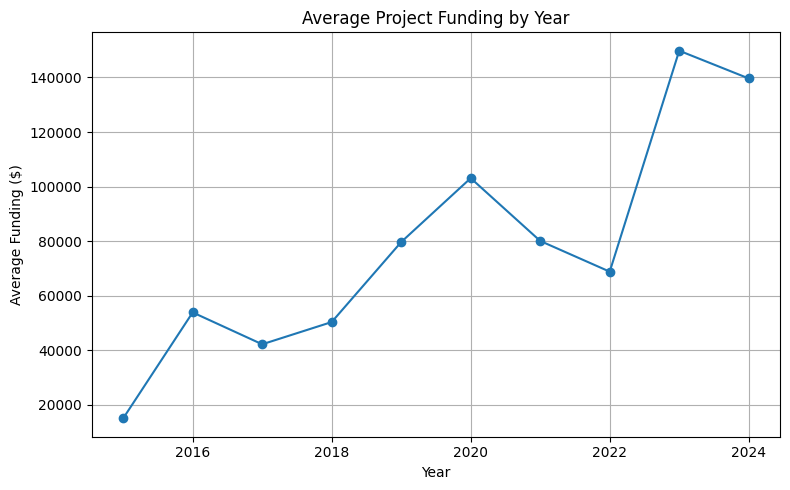

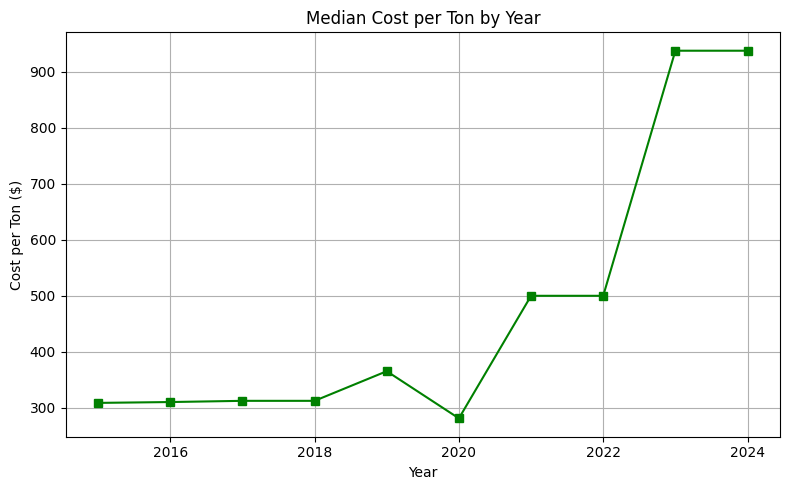

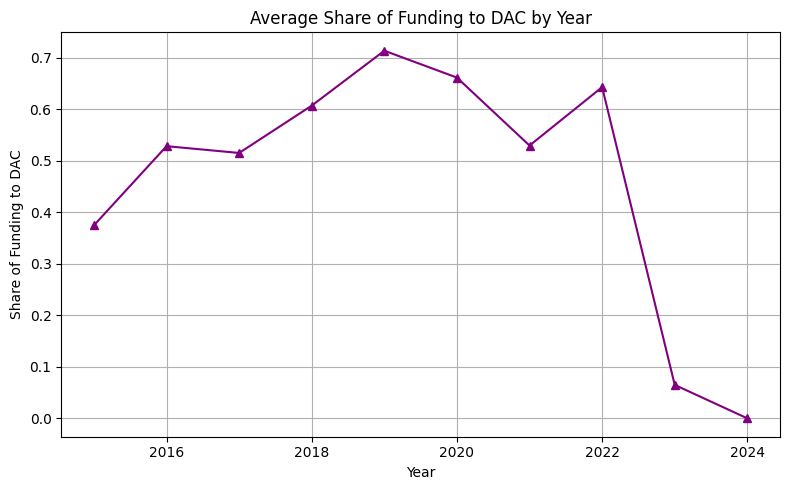

In [6]:

# Annual summary stats
annual_stats = df.groupby('Year').agg(
    avg_funding=('Total Program GGRFFunding', 'mean'),
    median_cost_per_ton=('cost_per_ton', 'median'),
    avg_share_DAC=('share_DAC', 'mean'),
    project_count=('cost_per_ton', 'count')
).dropna()

# Plot 1: Average Project Funding
plt.figure(figsize=(8, 5))
plt.plot(annual_stats.index, annual_stats['avg_funding'], marker='o')
plt.title('Average Project Funding by Year')
plt.xlabel('Year')
plt.ylabel('Average Funding ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Median Cost per Ton
plt.figure(figsize=(8, 5))
plt.plot(annual_stats.index, annual_stats['median_cost_per_ton'], marker='s', color='green')
plt.title('Median Cost per Ton by Year')
plt.xlabel('Year')
plt.ylabel('Cost per Ton ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Average Share of Funding to DAC
plt.figure(figsize=(8, 5))
plt.plot(annual_stats.index, annual_stats['avg_share_DAC'], marker='^', color='purple')
plt.title('Average Share of Funding to DAC by Year')
plt.xlabel('Year')
plt.ylabel('Share of Funding to DAC')
plt.grid(True)
plt.tight_layout()
plt.show()

Chart Captions

    Figure 1. Average Project Funding by Year (2015–2024)
    This figure displays the average dollar amount allocated per project under the CCI program annually. Funding levels increased significantly post-2020, indicating a potential shift in program scale or administrative strategy.

    Figure 2. Median Cost per Ton of GHG Reduction by Year (2015–2024)
    This figure illustrates changes in program efficiency over time, measured as the median cost per ton of greenhouse gas emissions reduced. Median costs rose steadily after 2020, suggesting potential diseconomies of scale or implementation challenges.

    Figure 3. Average Share of Funding to Disadvantaged Communities (DACs) by Year (2015–2024)
    This figure shows the average proportion of funding directed toward disadvantaged communities. While early years exceed statutory minimums, equity-focused allocations declined beginning in 2020, raising questions about evolving implementation priorities.
    